In [1]:
import os
from alpaca.data.historical.option import OptionHistoricalDataClient
from alpaca.trading.requests import GetOptionContractsRequest
from alpaca.data.requests import StockBarsRequest
from alpaca.trading.enums import AssetStatus, ContractType
from alpaca.trading.client import TradingClient
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.stock import StockHistoricalDataClient
# to run async code in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

underlying_symbol = 'AAPL'
risk_free_rate = 0.01


secret_key = os.getenv('ALPACA_MARKETS_SECRET_KEY')
api_key = os.getenv('ALPACA_MARKETS_API_KEY')

paper = True 
trade_api_url = None
trade_api_wss = None
data_api_url = None
stream_data_wss = None

option_data=OptionHistoricalDataClient(api_key, secret_key)

#last_price = 100
#min_strike = round(last_price * 1.02, 2)

today = datetime.now().date()
min_expiration = today + timedelta(days=14)
max_expiration = today + timedelta(days=90)

trade_client = TradingClient(api_key=api_key, secret_key=secret_key, paper=paper, url_override=trade_api_url)

req = GetOptionContractsRequest(
    underlying_symbols=[underlying_symbol],
    status= AssetStatus.ACTIVE,
    expiration_date=None,
    #expiration_date_gte=min_expiration,
    #expiration_date_lte=max_expiration,
    root_symbol=underlying_symbol,
    #type=ContractType.CALL,
    style=None,
    #strike_price_gte=min_strike,
    strike_price_lte=None,
    limit=None,
    page_token=None,
)

res = trade_client.get_option_contracts(req)
option_chain_list = res.option_contracts


stock_historical_data_client = StockHistoricalDataClient(api_key, secret_key, url_override = data_api_url)

def get_stdev(symbol):
    now = datetime.now()#ZoneInfo("America/New_York"))
    req = StockBarsRequest(
        symbol_or_symbols = [symbol],
        timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Hour),
        start = now - timedelta(days = 5*365),  
        #limit = 2,                                   
    )
    df_stock=stock_historical_data_client.get_stock_bars(req).df

    import numpy as np

    df_stock['log_ret'] = np.log(df_stock['close']/df_stock['close'].shift(1))
    stdev = df_stock['log_ret'].std()
    return stdev, float(df_stock['close'].iloc[-1])

stdev, last_price = get_stdev(underlying_symbol)

In [2]:
import math
import numpy as np
from scipy.stats import norm

def extract_data(option_chain):
    try:
        S = float(option_chain.close_price)
        K = float(option_chain.strike_price)
        T = (option_chain.expiration_date - option_chain.close_price_date).days / 365
        option_type = option_chain.type
        
        return S,K,T,option_type#, symbol
    except:
        return None, None, None, None

def black_scholes(option_chain,stdev, risk_free_rate=0.01):

    try:
        S,K,T,option_type = extract_data(option_chain)
    except:
        return None
    if S is None:
        return None

    d1 = (np.log(S/K) + (risk_free_rate + 0.5 * stdev**2) * T) / (stdev * np.sqrt(T))
    d2 = d1 - stdev * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-risk_free_rate * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-risk_free_rate * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError('Option type not recognized')
    
# Create a dictionary to store option premiums
option_premiums = {}
for i,o in enumerate(option_chain_list):
    #print(i,extract_data(o))
    premium = black_scholes(o, stdev=stdev, risk_free_rate=risk_free_rate)
    option_premiums[o.id] = premium

# Sort option_premiums by value (premium) in descending order
sorted_premiums = dict(sorted(option_premiums.items(), key=lambda x: float('-inf') if x[1] is None else x[1], reverse=True))

# Display top 10 options with highest premiums
print("Top 10 options with highest prices:")
for id, premium in list(sorted_premiums.items())[:10]:
    if premium is not None:  # Skip None values
        print(f"{id}: ${premium:.2f}")

Top 10 options with highest prices:
76f3d84e-7049-4e2d-ac31-50a2d277335b: $235.20
6f9e3611-e514-411b-a48b-d0b79eb57248: $234.92
6c5fd12d-5608-4cf4-8a49-f096c11ab0a5: $234.25
97052032-0e2f-4ab5-af28-f449d81ce576: $233.40
ab451430-95d8-47ca-89cb-49a9cb3fecae: $232.04
ff2edf2f-071e-4936-833a-0a2ab8354f23: $230.41
f4d63063-483b-4558-9669-c12016773d5e: $228.58
6dedcdd0-32fc-4469-8c2a-75bd6fe6807a: $226.50
3b022cf6-e57b-4ae5-b324-2fb28055aa5d: $224.30
c3aab09e-f5ed-4287-bcf3-b04bc2bed224: $222.00


In [3]:
option_id='76f3d84e-7049-4e2d-ac31-50a2d277335b'

option = next((opt for opt in option_chain_list if opt.id == option_id), None)
if option:
    S, K, T, option_type = extract_data(option)
    premium = black_scholes(option, stdev=stdev, risk_free_rate=risk_free_rate)
    print(f'Black-Scholes Premium for {option_id}: ${premium:.2f}')

Black-Scholes Premium for 76f3d84e-7049-4e2d-ac31-50a2d277335b: $235.20


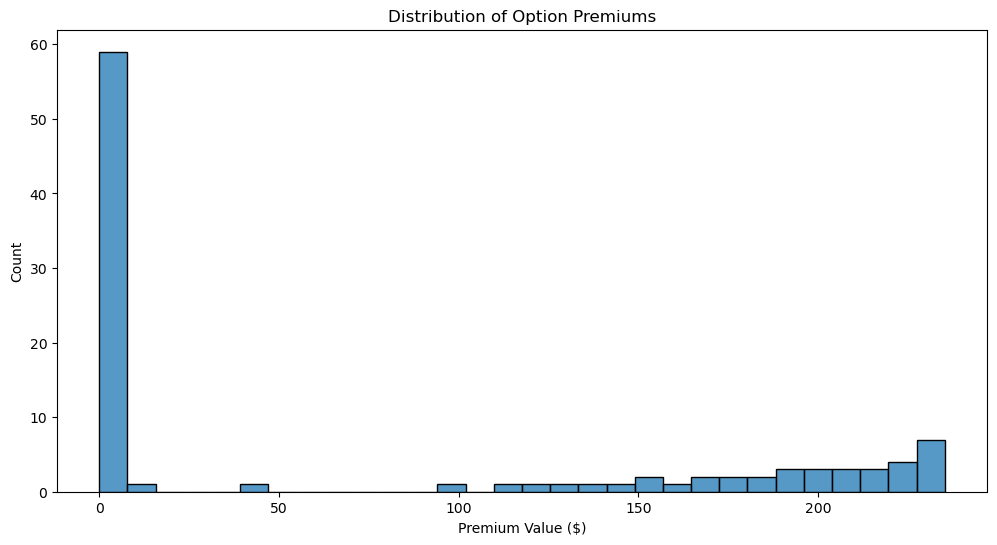

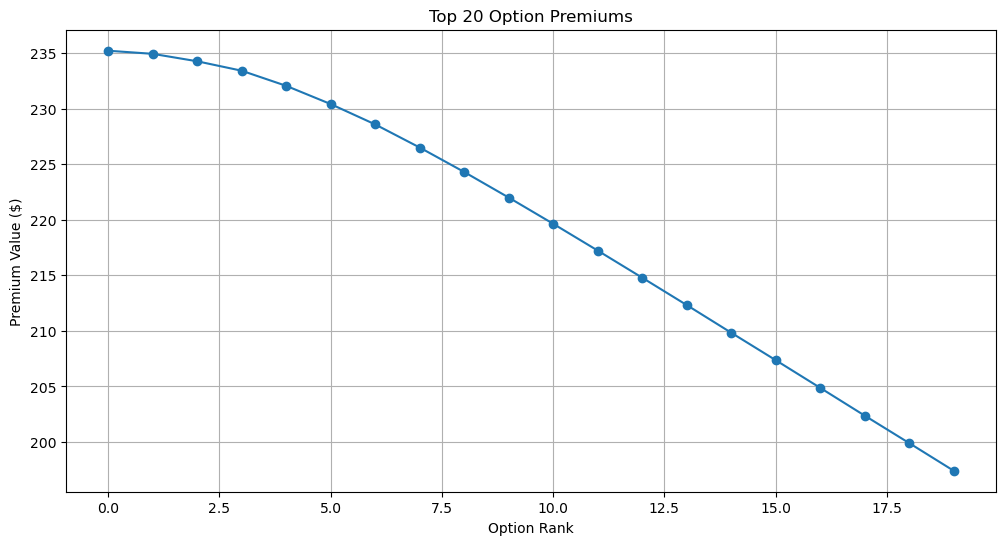

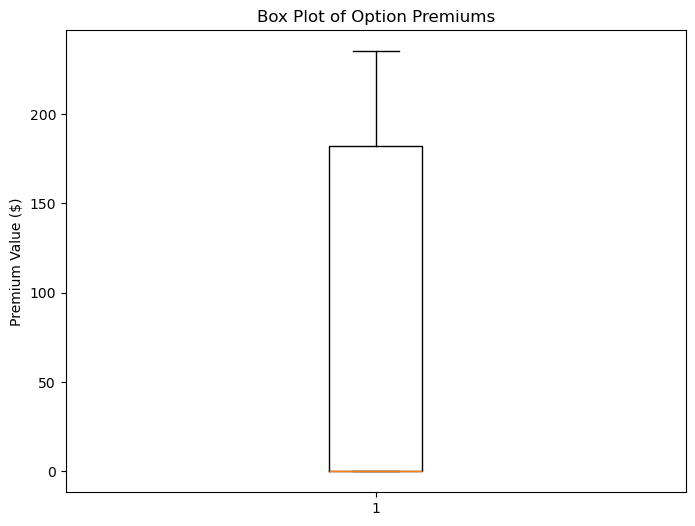

In [4]:
import seaborn as sns

import matplotlib.pyplot as plt

# Convert sorted_premiums to a list of tuples and filter out None values
premium_data = [(k, v) for k,v in sorted_premiums.items() if v is not None]
premiums = [v for _,v in premium_data]
option_ids = [k for k,_ in premium_data]

# Create a distribution plot of option premiums
plt.figure(figsize=(12, 6))
sns.histplot(data=premiums, bins=30)
plt.title('Distribution of Option Premiums')
plt.xlabel('Premium Value ($)')
plt.ylabel('Count')
plt.show()

# Create a line plot of top 20 premiums
plt.figure(figsize=(12, 6))
plt.plot(premiums[:20], marker='o')
plt.title('Top 20 Option Premiums')
plt.xlabel('Option Rank')
plt.ylabel('Premium Value ($)')
plt.grid(True)
plt.show()

# Box plot of premiums
plt.figure(figsize=(8, 6))
plt.boxplot(premiums)
plt.title('Box Plot of Option Premiums')
plt.ylabel('Premium Value ($)')
plt.show()